## LFV Limits from $\ell_i\rightarrow\ell_j\gamma$ decay rate

In this notebook, we generate limits on LFV scalars and ALPs for the $\ell_i \rightarrow \ell_j\gamma$ decay rates. 

In [1]:
#For numerics
import numpy as np

#For loading and saving data
import pandas as pd

#For plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

#For colorblind plots
import seaborn
colors = list(seaborn.color_palette('colorblind').as_hex())

#For TeX plots
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

#For setting root path
import sys
import os

root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if root not in sys.path:
    sys.path.append(root)
    
if os.getcwd() != root:
    os.chdir(root)

#suppress warnings
import warnings
warnings.filterwarnings('ignore')
    
#limits
from lfv_lepton_observables.limits import (radiative_processes,
                                           radiative_decay_limit,
                                           trilepton_processes,
                                           trilepton_decay_limit)

In [2]:
leptons = ['e', '\\mu', '\\tau']

def radiative_label(process):
    i, j = process
    return f'${leptons[i]}\\rightarrow {leptons[j]}\\gamma$'
    
def trilepton_label(process):
    i, j, k, l = process
    return f'${leptons[i]}\\rightarrow {leptons[j]}{leptons[k]}\\bar{{{leptons[l]}}}$'

def radiative_contributes(radiative_process, idx, g = None):
    i, j, k, l = idx
    ii, jj = radiative_process
    if g is None:
        g = np.zeros((3, 3))
        g[i][j] = 1
        g[j][i] = 1
        g[l][k] = 1
        g[k][l] = 1

    return bool(np.sum([g[ii][kk]*g[kk][jj] != 0  for kk in range(3)]))

def tree_level_contributes(trilepton_process, idx, g = None):
    ii, jj, kk, ll = trilepton_process
    i, j, k, l = idx
    
    if g is None:
        g = np.zeros((3, 3))
        g[i][j] = 1
        g[j][i] = 1
        g[l][k] = 1
        g[k][l] = 1

    return bool((g[ii][jj]*g[kk][ll] != 0) + (g[ii][kk] * g[jj][ll] != 0))
    
def plot_limit(m, idx, ax = None, g = None,
               th = [[0]*3]*3, d = [[0]*3]*3, ph = [[0]*3]*3,
               mode = None, ALP = False, Lam = 1000, which = 'radiative', **plot_kwargs):

    if ax == None:
        ax = plt.gca()
    
    i, j, k, l = idx 

    labels = []
    if which == 'radiative':
        for process in radiative_processes:
            limit = radiative_decay_limit(m, process, idx, g, th, d, ph, mode, ALP, Lam)
            if radiative_contributes(process, idx, g = g):            
                ax.plot(m, limit, **plot_kwargs)
                labels.append(radiative_label(process))
    
    if which == 'trilepton':
        for process in trilepton_processes:
            limit = trilepton_decay_limit(m, process, idx, g, th, d, ph, mode, ALP, Lam)
            if tree_level_contributes(process, idx, g = g):
                ax.plot(m, limit, **plot_kwargs)
                labels.append(trilepton_label(process))
    return ax, labels

def plot_limits(m, i, j, ax = None, g = None, ALP = False):
    if ax == None:
        ax = plt.gca()
    for k in range(3):
        plot_limit(m, (i, k, k, j), ax = ax, which = 'radiative', g = g, mode = 'PC', ALP = ALP, color = colors[k], linewidth = 2)
        plot_limit(m, (i, k, k, j), ax = ax, which = 'radiative', g = g, mode = 'chiral', ALP = ALP, color = colors[k], linestyle = 'dashed')
        
        _, labels = plot_limit(m, (i, k, k, j), ax = ax, which = 'trilepton', g = g, mode = 'PC', ALP = ALP, color = colors[k], linewidth = 2, alpha = 0.5)
        plot_limit(m, (i, k, k, j), ax = ax, which = 'trilepton', g = g, mode = 'chiral', ALP = ALP, color = colors[k], alpha = 0.5, linestyle = 'dashed')

    lines = [line.get_ydata() for line in ax.get_lines()]
    plt.fill_between(m, np.min(lines, axis = 0), 1e3, color = colors[8], alpha = 0.1)
    

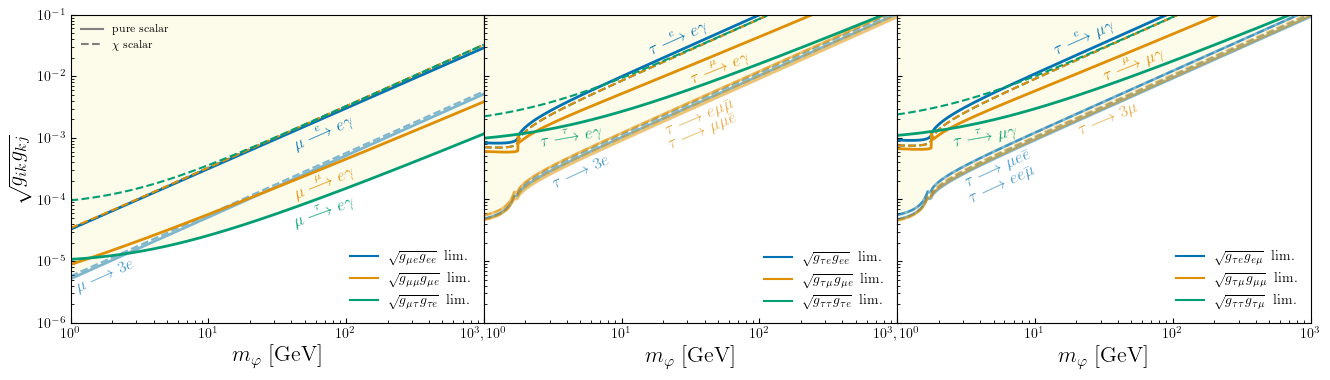

In [3]:
m = np.geomspace(1e0, 1e3, 1000)

fig = plt.figure(figsize = (16, 4))
gs = GridSpec(1, 3, figure = fig, wspace = 0)
axes = []
for idx, process in enumerate([(1, 0), (2, 0), (2, 1)]):
    i, j = process
    ax = fig.add_subplot(gs[idx])
    plot_limits(m, i, j, ax = ax)
    
    ax.tick_params(which = 'both', direction = 'in')
    if idx == 0:
        ax.set_ylabel("$\\sqrt{g_{ik}g_{kj}}$", fontsize = 16)
    ax.set_xlabel("$m_\\varphi~[{\\rm GeV}]$", fontsize = 16)
    
    if idx > 0:
        ax.tick_params(labelleft = False)
        ax.set_ylabel(None)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e0, 1e3)
    ax.set_ylim(1e-6, 1e-1)

    #fix xticks
    xticks = [1e0, 1e1, 1e2] if idx < 2 else [1e0, 1e1, 1e2, 1e3]
    xtick_labels = ["$10^0$", "$10^1$", "$10^2$"] if idx == 0 else ["$10^3, 10^0$", "$10^1$", "$10^2$"]
    if idx == 2:
        xtick_labels += ["$10^3$"]
    ax.set_xticks(xticks, xtick_labels)

    #legends
    plt.plot([0], [1e3], color = 'grey', linestyle = 'solid', label = '$\\textrm{pure scalar}$')
    plt.plot([0], [1e3], color = 'grey', linestyle = 'dashed', label = '$\\chi\\textrm{ scalar}$')
    if idx == 0:
        legend = ax.legend(frameon = False, loc = 'upper left', fontsize = 8)
        ax.add_artist(legend)
    for k in range(3):
        ax.plot([0], [1e3], color = colors[k], label = f'$\\sqrt{{g_{{{leptons[i]} {leptons[k]}}}g_{{{leptons[k]} {leptons[j]}}}}}~~{{\\rm lim.}}$')
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[-3:]
        labels = labels[-3:]
        ax.legend(handles, labels, frameon = False, loc = 'lower right')
    axes.append(ax)

#text 
axes[0].text(40, 6.2e-4, '$\\mu \\stackrel{e}{\\longrightarrow} e\\gamma$', rotation = 24, fontsize = 12, color = colors[0])
axes[0].text(40, 1e-4, '$\\mu \\stackrel{\\mu}{\\longrightarrow} e\\gamma$', rotation = 22, fontsize = 12, color = colors[1])
axes[0].text(40, 3.5e-5, '$\\mu \\stackrel{\\tau}{\\longrightarrow} e\\gamma$', rotation = 20, fontsize = 12, color = colors[2])
axes[0].text(1.05e0, 3.1e-6, '$\\mu \\longrightarrow 3e$', rotation = 24, fontsize = 12, color = colors[0], alpha = 0.75)

#text 
axes[1].text(15, 2.2e-2, '$\\tau \\stackrel{e}{\\longrightarrow} e\\gamma$', rotation = 24, fontsize = 12, color = colors[0])
axes[1].text(30, 7.4e-3, '$\\tau \\stackrel{\\mu}{\\longrightarrow} e\\gamma$', rotation = 22, fontsize = 12, color = colors[1])
axes[1].text(2.5, 7e-4, '$\\tau \\stackrel{\\tau}{\\longrightarrow} e\\gamma$', rotation = 10, fontsize = 12, color = colors[2])
axes[1].text(3, 1.5e-4, '$\\tau \\longrightarrow 3e$', rotation = 25, fontsize = 12, color = colors[0], alpha = 0.75)
axes[1].text(20, 1.1e-3, '$\\tau \\longrightarrow e \\mu\\bar{\\mu}$', rotation = 23, fontsize = 12, color = colors[1], alpha = 0.75)
axes[1].text(21, 6.5e-4, '$\\tau \\longrightarrow \\mu \\mu\\bar{e}$', rotation = 23, fontsize = 12, color = colors[1], alpha = 0.75)

#text 
axes[2].text(13, 2.2e-2, '$\\tau \\stackrel{e}{\\longrightarrow} \\mu\\gamma$', rotation = 24, fontsize = 12, color = colors[0])
axes[2].text(30, 8.3e-3, '$\\tau \\stackrel{\\mu}{\\longrightarrow} \\mu\\gamma$', rotation = 22, fontsize = 12, color = colors[1])
axes[2].text(2.5, 7e-4, '$\\tau \\stackrel{\\tau}{\\longrightarrow} \\mu\\gamma$', rotation = 10, fontsize = 12, color = colors[2])
axes[2].text(20, 1.1e-3, '$\\tau \\longrightarrow 3\\mu$', rotation = 23, fontsize = 12, color = colors[1], alpha = 0.75)
axes[2].text(3, 1.55e-4, '$\\tau \\longrightarrow \\mu e \\bar{e}$', rotation = 25, fontsize = 12, color = colors[0], alpha = 0.75)
axes[2].text(3.2, 8.5e-5, '$\\tau \\longrightarrow ee\\bar{\\mu}$', rotation = 25, fontsize = 12, color = colors[0], alpha = 0.75)

plt.savefig('figures/chapter3/lfv_scalar_lepton_decay_limits.pdf', format = 'pdf', bbox_inches='tight')

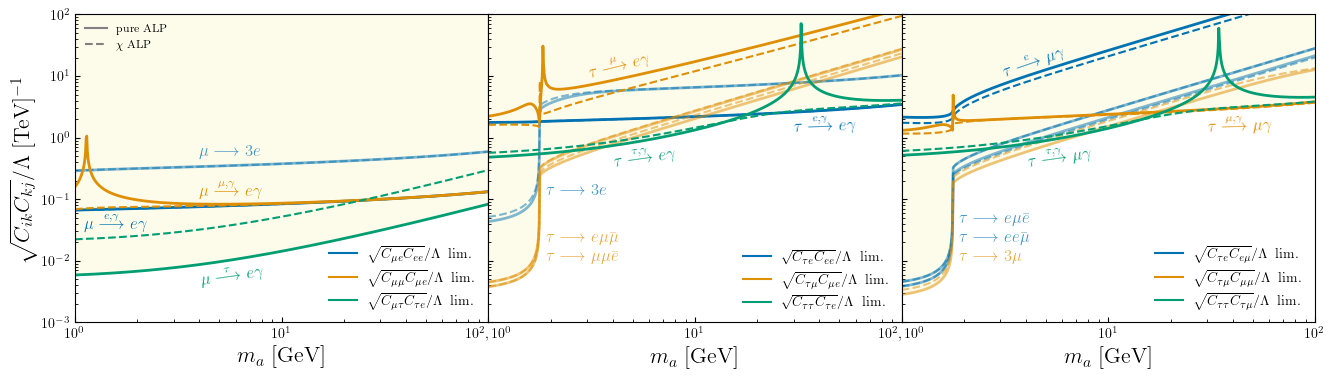

In [4]:
fig = plt.figure(figsize = (16, 4))
gs = GridSpec(1, 3, figure = fig, wspace = 0)

axes = []
for idx, process in enumerate([(1, 0), (2, 0), (2, 1)]):
    i, j = process
    ax = fig.add_subplot(gs[idx])
    plot_limits(m, *process, ax = ax, ALP = 'True')
    
    ax.tick_params(which = 'both', direction = 'in')
    if idx == 0:
        ax.set_ylabel("$\\sqrt{C_{ik}C_{kj}}/\\Lambda~[{\\rm TeV}]^{-1}$", fontsize = 16)
    if idx > 0:
        ax.tick_params(labelleft = False)
        ax.set_ylabel(None)
    ax.set_xlabel("$m_a~[{\\rm GeV}]$", fontsize = 16)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e0, 1e2)
    ax.set_ylim(1e-3, 1e2)

    #fix xticks
    xticks = [1e0, 1e1] if idx < 2 else [1e0, 1e1, 1e2]
    xtick_labels = ["$10^0$", "$10^1$"] if idx == 0 else ["$10^2, 10^0$", "$10^1$"]
    if idx == 2:
        xtick_labels += ["$10^2$"]
    ax.set_xticks(xticks, xtick_labels)

    #legends
    plt.plot([0], [1e3], color = 'grey', linestyle = 'solid', label = '$\\textrm{pure ALP}$')
    plt.plot([0], [1e3], color = 'grey', linestyle = 'dashed', label = '$\\chi\\textrm{ ALP}$')
    if idx == 0:
        legend = ax.legend(frameon = False, loc = 'upper left', fontsize = 8)
        ax.add_artist(legend)
    for k in range(3):
        ax.plot([0], [1e3], color = colors[k], label = f'$\\sqrt{{C_{{{leptons[i]} {leptons[k]}}}C_{{{leptons[k]} {leptons[j]}}}}}/\\Lambda~~{{\\rm lim.}}$')
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[-3:]
        labels = labels[-3:]
        ax.legend(handles, labels, frameon = False, loc = 'lower right')
        
    axes.append(ax)

#text 
axes[0].text(1.1, 3.2e-2, '$\\mu \\stackrel{e,\\gamma}{\\longrightarrow} e\\gamma$', rotation = 0, fontsize = 12, color = colors[0])
axes[0].text(4, 1.1e-1, '$\\mu \\stackrel{\\mu,\\gamma}{\\longrightarrow} e\\gamma$', rotation = 0, fontsize = 12, color = colors[1])
axes[0].text(4, 4e-3, '$\\mu \\stackrel{\\tau}{\\longrightarrow} e\\gamma$', rotation = 8, fontsize = 12, color = colors[2])
axes[0].text(4, 5e-1, '$\\mu \\longrightarrow 3e$', rotation = 0, fontsize = 12, color = colors[0], alpha = 0.75)

#text 
axes[1].text(30, 1.2, '$\\tau \\stackrel{e,\\gamma}{\\longrightarrow} e\\gamma$', rotation = 2, fontsize = 12, color = colors[0])
axes[1].text(3, 9.2, '$\\tau \\stackrel{\\mu}{\\longrightarrow} e\\gamma$', rotation = 14, fontsize = 12, color = colors[1])
axes[1].text(4, 3.3e-1, '$\\tau \\stackrel{\\tau,\\gamma}{\\longrightarrow} e\\gamma$', rotation = 8, fontsize = 12, color = colors[2])
axes[1].text(1.9, 1.2e-1, '$\\tau \\longrightarrow 3e$', fontsize = 12, color = colors[0], alpha = 0.75)
axes[1].text(1.9, 2e-2, '$\\tau \\longrightarrow e \\mu\\bar{\\mu}$', fontsize = 12, color = colors[1], alpha = 0.75)
axes[1].text(1.9, 1e-2, '$\\tau \\longrightarrow \\mu \\mu\\bar{e}$', fontsize = 12, color = colors[1], alpha = 0.75)

#text 
axes[2].text(3, 9.5, '$\\tau \\stackrel{e}{\\longrightarrow} \\mu\\gamma$', rotation = 19, fontsize = 12, color = colors[0])
axes[2].text(30, 1.2, '$\\tau \\stackrel{\\mu,\\gamma}{\\longrightarrow} \\mu\\gamma$', rotation = 2, fontsize = 12, color = colors[1])
axes[2].text(4, 3.3e-1, '$\\tau \\stackrel{\\tau,\\gamma}{\\longrightarrow} \\mu\\gamma$', rotation = 8, fontsize = 12, color = colors[2])
axes[2].text(1.9, 4e-2, '$\\tau \\longrightarrow e\\mu \\bar{e}$', fontsize = 12, color = colors[0], alpha = 0.75)
axes[2].text(1.9, 2e-2, '$\\tau \\longrightarrow ee\\bar{\\mu}$', fontsize = 12, color = colors[0], alpha = 0.75)
axes[2].text(1.9, 1e-2, '$\\tau \\longrightarrow 3\\mu$', fontsize = 12, color = colors[1], alpha = 0.75)

plt.savefig('figures/chapter3/lfv_alp_lepton_decay_limits.pdf', format = 'pdf', bbox_inches='tight')